In [1]:

%pprint

Pretty printing has been turned OFF



---
# Load needed libraries and functions

In [2]:

%matplotlib inline
from datetime import datetime
from neo4j.exceptions import ServiceUnavailable
import humanize
import openai
import os
import sys
import time
import warnings
import winsound

warnings.filterwarnings('ignore')
duration = 1000  # milliseconds
freq = 880  # Hz

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

In [3]:

t0 = t1 = time.time()

# Get the Neo4j driver
from storage import Storage
s = Storage(
    data_folder_path=os.path.abspath('../data'),
    saves_folder_path=os.path.abspath('../saves')
)

from scrape_utils import WebScrapingUtilities
wsu = WebScrapingUtilities(
    s=s,
    secrets_json_path=os.path.abspath('../data/secrets/jh_secrets.json')
)
openai.api_key = wsu.secrets_json['OPENAI_API_KEY']
uri = wsu.secrets_json['neo4j']['connect_url']
user =  wsu.secrets_json['neo4j']['username']
password = wsu.secrets_json['neo4j']['password']

from ha_utils import HeaderAnalysis
ha = HeaderAnalysis(s=s, verbose=False)

# Get the Neo4j object
from cypher_utils import CypherUtilities
cu = CypherUtilities(
    uri=uri, user=user, password=password, driver=None, s=s, ha=ha
)

duration_str = humanize.precisedelta(time.time() - t1, minimum_unit='seconds', format='%0.0f')
print(f'Utility libraries created in {duration_str}')

Utility libraries created in 0 seconds


In [1]:

from scrapeghost import SchemaScraper

scrape_legislators = SchemaScraper(
  schema={
      'name': 'string',
      'url': 'url',
      'district': 'string',
      'party': 'string',
      'photo_url': 'url',
      'offices': [{'name': 'string', 'address': 'string', 'phone': 'string'}],
  }
)

In [2]:

resp = scrape_legislators('https://www.ilga.gov/house/rep.asp?MemberID=3071')
resp.data

2023-03-26 15:57:36 [debug    ] got HTML                       length=13491 url=https://www.ilga.gov/house/rep.asp?MemberID=3071
2023-03-26 15:57:36 [debug    ] preprocessor                   from_nodes=1 name=CleanHTML nodes=1
2023-03-26 15:57:37 [info     ] API request                    html_tokens=2579 model=gpt-3.5-turbo
2023-03-26 15:57:45 [info     ] API response                   completion_tokens=218 cost=0.005842 duration=8.482907056808472 finish_reason=stop prompt_tokens=2703
2023-03-26 15:57:45 [debug    ] postprocessor                  data={
  "name": "Emanuel \"Chris\" Welch",
  "url": "https://www.ilga.gov/house/Rep.asp?GA=102&MemberID=3071",
  "district": "7th",
  "party": "D",
  "photo_url": "https://www.ilga.gov/images/members/%7B5D419B94-66B4-4F3B-86F1-BFF37B3FA55C%7D.jpg",
  "offices": [
    {
      "name": "Springfield Office:",
      "address": "300 Capitol Building Springfield, IL   62706",
      "phone": "(217) 782-5350"
    },
    {
      "name": "District Off

PostprocessingError: Data not found in html: https://www.ilga.gov/house/Rep.asp?GA=102&MemberID=3071 (parent: .url)

In [5]:

from scrapeghost import SchemaScraper
from pprint import pprint

url = 'https://comedybangbang.fandom.com/wiki/Operation_Golden_Orb'
schema = {
    'title': 'str',
    'episode_number': 'int',
    'release_date': 'str',
}

episode_scraper = SchemaScraper(schema)
try:
    response = episode_scraper(url)
    pprint(response.data)
    print(f'Total Cost: ${response.total_cost:.3f}')
except Exception as e:
    print(f'{e.__class__} error: {str(e).strip()}')

2023-03-26 16:26:40 [debug    ] got HTML                       length=165180 url=https://comedybangbang.fandom.com/wiki/Operation_Golden_Orb
2023-03-26 16:26:40 [debug    ] preprocessor                   from_nodes=1 name=CleanHTML nodes=1
<class 'scrapeghost.errors.TooManyTokens'> error: HTML is 11958 tokens, max for gpt-3.5-turbo is 4096


In [5]:

import scrapeghost

dir(scrapeghost)

['CSS', 'SchemaScraper', 'XPath', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'apicall', 'cost_estimate', 'errors', 'postprocessors', 'preprocessors', 'responses', 'scrapers', 'utils']

In [7]:

# Show what's in the database already for this html string
def do_cypher_tx(tx, verbose=False):
    cypher_str = '''
        MATCH (fn:FileNames)
        WHERE
            (fn.percent_fit >= 0.8) AND
            ((fn.is_closed IS NULL) OR (fn.is_closed = false)) AND
            ((fn.is_opportunity_application_emailed IS NULL) OR (fn.is_opportunity_application_emailed = false))
        RETURN
            fn.percent_fit AS percent_fit,
            fn.file_name AS file_name,
            fn.posting_url AS posting_url
        ORDER BY fn.percent_fit DESC;'''
    results_list = tx.run(query=cypher_str, parameters={})

    return [dict(record.items()) for record in results_list]
with cu.driver.session() as session:
    row_objs_list = session.write_transaction(do_cypher_tx, verbose=False)
row_objs_list

[{'percent_fit': 1.0, 'file_name': 'f9eb1389644151d9_Data_Operations_Engineer_Remote_Remote_Indeed_com.html', 'posting_url': 'https://www.indeed.com/rc/clk/dl?jk=f9eb1389644151d9&from=ja&qd=RnZhMybXSk4M3QtTVGXWocPDA-jVn_f73KUcK2QrGXxWzxuTTZnceBTcgT1wk7VUo-bXDKl1ImijYZhUV9SeWA-WVeNBgck-w1Fi5Baf52g&rd=KaXlx5fp5X_mVf8_2PYUAl_MKnaSAFGAsD6kfERFt3g&tk=1gs7bdi12p37l800&alid=63b02dca1ef86228dd5d5128'}, {'percent_fit': 1.0, 'file_name': 'mrBArBiUFWdh0zxQ3TSjiQ_Data_Scientist_Python_SQL_Remote_7750_USD_Mes_Listopro_Santiago_Santiago_Metropolitan_Region_Chile_Remote.html', 'posting_url': 'https://www.linkedin.com/comm/jobs/view/3528402447/?trackingId=mrBArBiUFWdh0zxQ3TSjiQ%3D%3D&refId=796d3d24-023c-405a-8405-a7b5336f004b&lipi=urn%3Ali%3Apage%3Aemail_email_job_alert_digest_01%3B9JK4HhEER12yugjbEfmUsg%3D%3D&midToken=AQGMOUshomUHaw&midSig=2w1GA3v5Bk3qI1&trk=eml-email_job_alert_digest_01-job_card-0-jobcard_body&trkEmail=eml-email_job_alert_digest_01-job_card-0-jobcard_body-null-31gqm~lffidpz4~3u-null

2023-03-26 16:51:47 [debug    ] got HTML                       length=5862 url=https://www.indeed.com/rc/clk/dl?jk=f9eb1389644151d9&from=ja&qd=RnZhMybXSk4M3QtTVGXWocPDA-jVn_f73KUcK2QrGXxWzxuTTZnceBTcgT1wk7VUo-bXDKl1ImijYZhUV9SeWA-WVeNBgck-w1Fi5Baf52g&rd=KaXlx5fp5X_mVf8_2PYUAl_MKnaSAFGAsD6kfERFt3g&tk=1gs7bdi12p37l800&alid=63b02dca1ef86228dd5d5128
2023-03-26 16:51:47 [debug    ] preprocessor                   from_nodes=1 name=CleanHTML nodes=1
2023-03-26 16:51:47 [info     ] API request                    html_tokens=604 model=gpt-3.5-turbo
2023-03-26 16:52:01 [info     ] API response                   completion_tokens=405 cost=0.0023840000000000003 duration=14.182557106018066 finish_reason=stop prompt_tokens=787
2023-03-26 16:52:01 [debug    ] postprocessor                  data={
  "<h1>Access denied</h1>": "str",
  "<span class=\"cf-code-label\">Error code <span>1020</span></span>": "str",
  "<p>You do not have access to www.indeed.com.</p><p>The site owner may have set restrictions
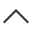
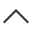
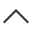

In [28]:

from scrapeghost import SchemaScraper, XPath
from pprint import pprint

url = row_objs_list[0]['posting_url']
schema = {
    '<h1 class="icl-u-xs-mb--xs icl-u-xs-mt--none jobsearch-JobInfoHeader-title">': 'str',
    '<b> As a DataOps Engineer, you....</b>': ['str'],
    '<b> Who makes a DatOps Engineer?</b>': ['str'],
}

episode_scraper = SchemaScraper(
    schema,
    # can pass preprocessor to constructor or at scrape time
    # extra_preprocessors=[XPath('//*[@id="jobDescriptionText"]')],
    extra_instructions=[
        'The important stuff is below the <h2 id="jobDescriptionTitle" class="jobsearch-JobDescriptionSection-jobDescriptionTitle icl-u-xs-my--md">Full Job Description</h2>.',
    ],
)
try:
    response = episode_scraper(url)
    pprint(response.data)
    print(f'Total Cost: ${response.total_cost:.3f}')
except Exception as e:
    print(f'{e.__class__} error: {str(e).strip()}')

In [11]:

url

'https://www.indeed.com/rc/clk/dl?jk=f9eb1389644151d9&from=ja&qd=RnZhMybXSk4M3QtTVGXWocPDA-jVn_f73KUcK2QrGXxWzxuTTZnceBTcgT1wk7VUo-bXDKl1ImijYZhUV9SeWA-WVeNBgck-w1Fi5Baf52g&rd=KaXlx5fp5X_mVf8_2PYUAl_MKnaSAFGAsD6kfERFt3g&tk=1gs7bdi12p37l800&alid=63b02dca1ef86228dd5d5128'